In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import mysql.connector
import numpy as np
db = mysql.connector.connect(host = "localhost", 
                             username = "root", 
                             password = "mysqldenim", 
                             database = "sales_project")
cur = db.cursor()

### LIST ALL UNIQUES CITIES WHERE CUSTOMERS ARE LOCATED

In [22]:
query_1 = """ SELECT DISTINCT CUSTOMER_CITY FROM CUSTOMERS """

cur.execute(query_1)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["CUSTOMER_CITY"])
df

,CUSTOMER_CITY
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


### COUNT NUMBER OF ORDERS PLACED IN 2017

In [8]:
query_2 = """ 
SELECT COUNT(ORDER_ID) 
FROM ORDERS WHERE ORDER_PURCHASE_TIMESTAMP REGEXP "^2017";
"""

cur.execute(query_2)
data = cur.fetchall()
data[0][0]

45101

### TOTAL SALES PER CATEGORY

In [9]:
query_3 = """ 
SELECT 
    UPPER(PRODUCTS.PRODUCT_CATEGORY) CATEGORY, 
    ROUND(SUM(PAYMENTS.PAYMENT_VALUE), 2) SALES
FROM PRODUCTS JOIN ORDER_ITEMS ON PRODUCTS.PRODUCT_ID = ORDER_ITEMS.PRODUCT_ID
JOIN PAYMENTS ON PAYMENTS.ORDER_ID = ORDER_ITEMS.ORDER_ID
GROUP BY CATEGORY; 
"""

cur.execute(query_3)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['CATEGORY', "TOTAL_SALES"])
df

,CATEGORY,TOTAL_SALES
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,FASHION BAGS AND ACCESSORIES,218158.28
4,BED TABLE BATH,1712553.67
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


### PERCENTAGE OF ORDERS THAT WERE PAID IN INSTALLMENTS

In [10]:
query_4 = """
SELECT (SUM(CASE WHEN PAYMENT_INSTALLMENTS > 1 THEN 1 ELSE 0 END))/COUNT(*) * 100
FROM PAYMENTS;
"""
cur.execute(query_4)
data = cur.fetchall()
data[0][0]

Decimal('49.4176')

### NUMBER OF CUSTOMERS FROM EACH STATE

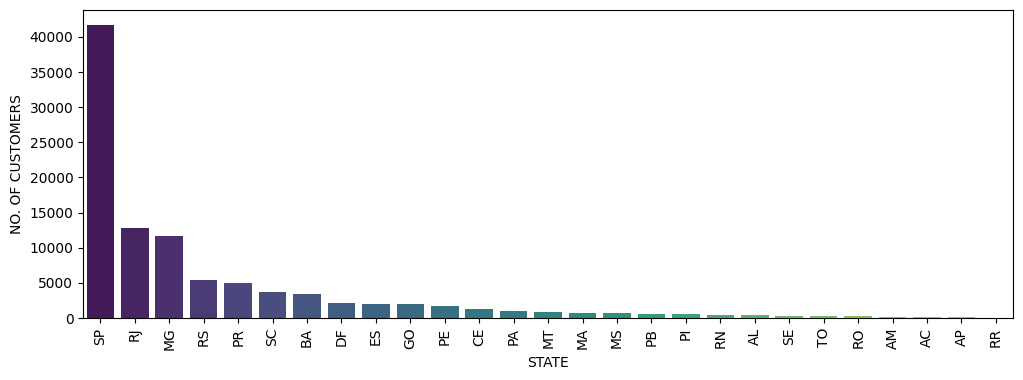

In [11]:
query_5 = """
SELECT 
    CUSTOMERS.CUSTOMER_STATE, 
    COUNT(CUSTOMERS.CUSTOMER_ID) 
FROM CUSTOMERS 
GROUP BY CUSTOMERS.CUSTOMER_STATE; """

cur.execute(query_5)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["STATE", "NO. OF CUSTOMERS"])

# Creating a new dataframe and plotting the values:

new_df = df.sort_values(by = "NO. OF CUSTOMERS", ascending = False)

plt.figure(figsize = (12,4))
sns.barplot(x = new_df["STATE"], y = new_df["NO. OF CUSTOMERS"], data = new_df, hue = new_df["STATE"], palette = "viridis")
plt.xticks(rotation = 90)
plt.show()

### NUMBER OF ORDERS PER MONTH IN 2018:

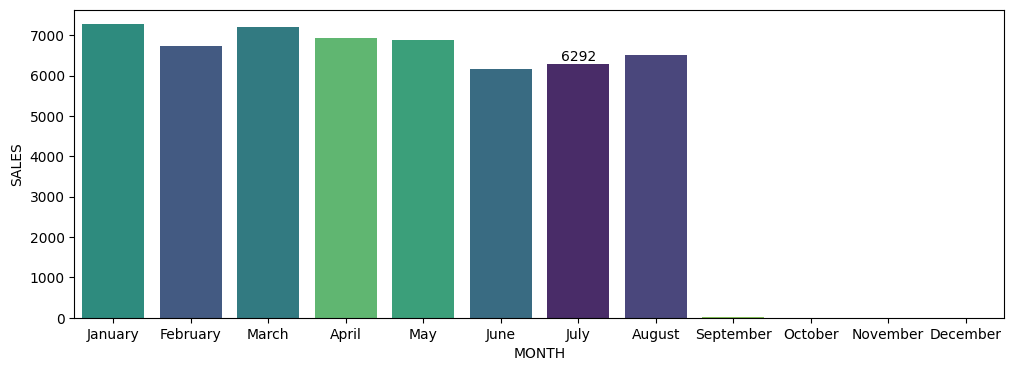

In [12]:
query_6 = """
SELECT 
    MONTHNAME(ORDER_PURCHASE_TIMESTAMP), 
    COUNT(ORDER_ID)
FROM ORDERS
WHERE YEAR(ORDER_PURCHASE_TIMESTAMP) = "2018"
GROUP BY MONTHNAME(ORDER_PURCHASE_TIMESTAMP); 
"""

cur.execute(query_6)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["MONTH", "SALES"])

plt.figure(figsize = (12,4))
o = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
ax = sns.barplot(x = df["MONTH"], y = df["SALES"], data= df, order = o, hue = df["MONTH"], palette = "viridis")
ax.bar_label(ax.containers[0])
plt.show()


### AVERAGE NUMBER OF PRODUCTS PER ORDER WHICH IS GROUPED IN ORDER OF CITY:

In [13]:
query_7 = """
WITH COUNT_PER_ORDER AS 
    (SELECT ORDERS.ORDER_ID, ORDERS.CUSTOMER_ID, COUNT(ORDER_ITEMS.ORDER_ITEM_ID) ORDER_COUNT
    FROM ORDERS JOIN ORDER_ITEMS ON ORDERS.ORDER_ID = ORDER_ITEMS.ORDER_ID
    GROUP BY ORDERS.ORDER_ID, ORDERS.CUSTOMER_ID)

SELECT 
    CUSTOMERS.CUSTOMER_CITY, 
    ROUND(AVG(ORDER_COUNT), 2)
FROM CUSTOMERS JOIN COUNT_PER_ORDER ON CUSTOMERS.CUSTOMER_ID = COUNT_PER_ORDER.CUSTOMER_ID
GROUP BY CUSTOMERS.CUSTOMER_CITY;
"""

cur.execute(query_7)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer_city", "Average_products_per_order"])
df.head()

,Customer_city,Average_products_per_order
0,sao jose dos campos,1.14
1,indaial,1.12
2,treze tilias,1.27
3,sao paulo,1.16
4,rio de janeiro,1.15


### PERCENT OF TOTAL REVENUE CONTRIBUTED BY EACH PRODUCT CATEGORY:

In [14]:
query_8 = """
WITH PR AS
    (SELECT UPPER(PRODUCTS.PRODUCT_CATEGORY) CATEGORY, ROUND(SUM(PAYMENTS.PAYMENT_VALUE), 2) SALES
    FROM PRODUCTS JOIN ORDER_ITEMS
    ON PRODUCTS.PRODUCT_ID = ORDER_ITEMS.PRODUCT_ID
    JOIN PAYMENTS
    ON PAYMENTS.ORDER_ID = ORDER_ITEMS.ORDER_ID
    GROUP BY CATEGORY)

SELECT CATEGORY, ROUND(SUM(SALES) / (SELECT SUM(PAYMENT_VALUE) FROM PAYMENTS) * 100, 2) TOTAL_REVENUE 
FROM PR
GROUP BY CATEGORY
ORDER BY SALES DESC; """

cur.execute(query_8)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['CATEGORY', "PERCENT REVENUE"])
df.head(10)

,CATEGORY,PERCENT REVENUE
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


### IDENTIFY THE CORRELATION BETWEEN PRODUCT PRICE AND THE NUMBER OF TIMES A PRODUCT HAS BEEN PURCHASED:

In [15]:
query_9 = """ SELECT PRODUCTS.PRODUCT_CATEGORY, COUNT(ORDER_ITEMS.PRODUCT_ID) NO_OF_PRODUCT, ROUND(AVG(ORDER_ITEMS.PRICE), 2) PRICE
FROM PRODUCTS JOIN ORDER_ITEMS
ON ORDER_ITEMS.PRODUCT_ID = PRODUCTS.PRODUCT_ID
GROUP BY PRODUCTS.PRODUCT_CATEGORY; """

cur.execute(query_9)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["CATEGORY", "NO OF PRODUCTS", "PRICE"])

# Finding Co-relation:

arr1 = df["NO OF PRODUCTS"]
arr2 = df["PRICE"]

a = np.corrcoef([arr1, arr2])
print("The Correlation is: ", a[0][1])

The Correlation is:  -0.10631514167157562


### TOTAL REVENUE GENERATED BY EACH SELLER, RANKING THEM BY REVENUE:

In [16]:
query_10 = """ SELECT *, DENSE_RANK() OVER(ORDER BY REVENUE) RANK_
FROM
(SELECT ORDER_ITEMS.SELLER_ID, ROUND(SUM(PAYMENTS.PAYMENT_VALUE), 2) REVENUE
FROM ORDER_ITEMS
JOIN PAYMENTS ON ORDER_ITEMS.ORDER_ID = PAYMENTS.ORDER_ID
GROUP BY ORDER_ITEMS.SELLER_ID
ORDER BY REVENUE DESC) AS A; """

cur.execute(query_10)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["SELLER_ID", "REVENUE", "RANK"])
ndf = df.head(10)
ndf

,SELLER_ID,REVENUE,RANK
0,cf6f6bc4df3999b9c6440f124fb2f687,12.22,1
1,77128dec4bec4878c37ab7d6169d6f26,15.22,2
2,4965a7002cca77301c82d3f91b82e1a9,16.36,3
3,702835e4b785b67a084280efca355756,18.56,4
4,ad14615bdd492b01b0d97922e87cb87f,19.21,5
5,3ac588cd562971392504a9e17130c40b,19.29,6
6,c1dde11f12d05c478f5de2d7319ad3b2,19.89,7
7,cc1f04647be106ba74e62b21f358af25,20.19,8
8,b5f0712d22a873b6797ab6cc65c3fcba,21.28,9
9,34aefe746cd81b7f3b23253ea28bef39,22.52,10


### MOVING AVERAGE Of ORDER VALUES FOR EACH CUSTOMER OVER THEIR ORDER HISTORY:

In [21]:
query_11 = """ SELECT CUSTOMER_ID, ORDER_PURCHASE_TIMESTAMP, PAYMENT_VALUE, 
AVG(PAYMENT_VALUE) 
OVER(PARTITION BY CUSTOMER_ID 
ORDER BY ORDER_PURCHASE_TIMESTAMP 
ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS MOVING_AVG
FROM (SELECT ORDERS.CUSTOMER_ID, ORDERS.ORDER_PURCHASE_TIMESTAMP, PAYMENTS.PAYMENT_VALUE
FROM ORDERS JOIN PAYMENTS ON ORDERS.ORDER_ID = PAYMENTS.ORDER_ID) AS A; """

cur.execute(query_11)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["CUSTOMER_ID", "ORDER_PURCHASE_TIMESTAMP", "PAYMENT", "MOVING AVERAGE"])
df

,CUSTOMER_ID,ORDER_PURCHASE_TIMESTAMP,PAYMENT,MOVING AVERAGE
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


### CUMULATIVE SALES PER MONTH FOR EACH YEAR:

In [18]:
query_12 = """ SELECT YEARS, MONTHS, PAYMENT, ROUND(SUM(PAYMENT) OVER(ORDER BY YEARS, MONTHS), 2) CUMULATIVE_SALES
FROM
(SELECT 
YEAR(ORDERS.ORDER_PURCHASE_TIMESTAMP) YEARS,
MONTH(ORDERS.ORDER_PURCHASE_TIMESTAMP) MONTHS,
ROUND(SUM(PAYMENTS.PAYMENT_VALUE), 2) PAYMENT
FROM ORDERS JOIN PAYMENTS ON PAYMENTS.ORDER_ID = ORDERS.ORDER_ID
GROUP BY YEARS, MONTHS
ORDER BY YEARS, MONTHS) AS A;
"""
cur.execute(query_12)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["YEAR", "MONTH", "SALES", "CUMULATIVE SALES"])
df.head(10)

,YEAR,MONTH,SALES,CUMULATIVE SALES
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


### YEAR-OVER-YEAR GROWTH RATE OF TOTAL SALES:

In [19]:
query_13 = """WITH YEAR_SALES AS
(SELECT 
YEAR(ORDERS.ORDER_PURCHASE_TIMESTAMP) YEARS,
ROUND(SUM(PAYMENTS.PAYMENT_VALUE), 2) SALES
FROM ORDERS JOIN PAYMENTS ON ORDERS.ORDER_ID = PAYMENTS.ORDER_ID
GROUP BY YEARS
ORDER BY YEARS)

SELECT YEARS, SALES, LAG(SALES, 1) OVER(ORDER BY YEARS) PREVIOUS_YEAR,
((SALES - LAG(SALES, 1) OVER(ORDER BY YEARS))/LAG(SALES, 1) OVER(ORDER BY YEARS)) * 100 AS YEAR_OVER_YEAR_GROWTH
FROM YEAR_SALES;
"""
cur.execute(query_13)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["YEAR", "SALES", "PREVIOUS_YEAR", "YEAR OVER YEAR % GROWTH"])
df

,YEAR,SALES,PREVIOUS_YEAR,YEAR OVER YEAR % GROWTH
0,2016,59362.34,NaN,NaN
1,2017,7249746.73,59362.34,12112.703761
2,2018,8699763.05,7249746.73,20.000924


###  TOP THREE CUSTOMERS WHO SPEND MOST MONEY EACH YEAR:

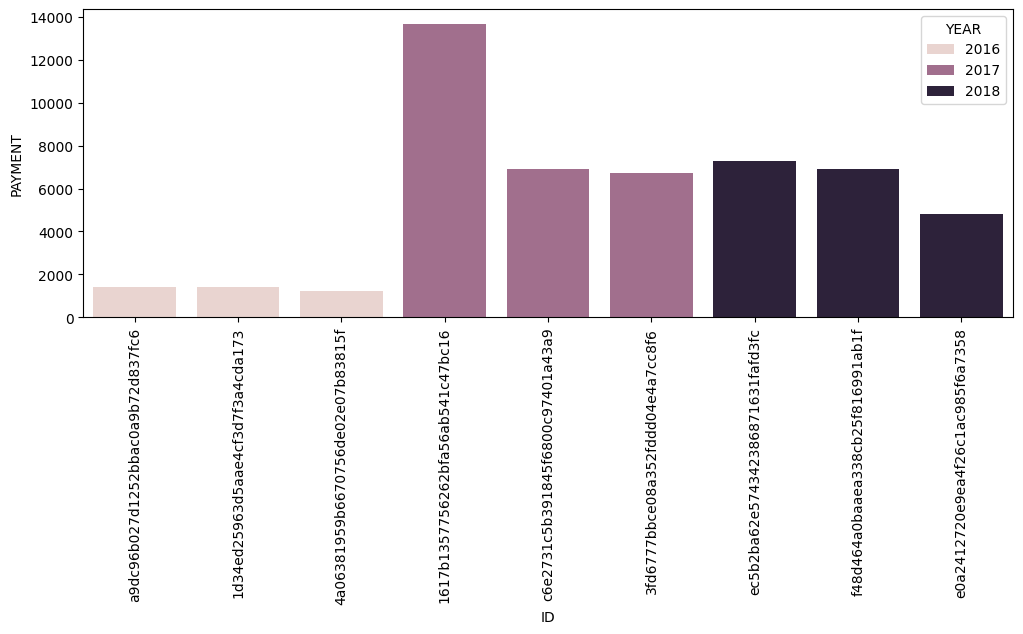

In [20]:
query_14 = """
SELECT CUSTOMER_ID, YEARS, PAYMENT, D_RANK
FROM
    (SELECT 
    	ORDERS.CUSTOMER_ID, 
        YEAR(ORDERS.ORDER_PURCHASE_TIMESTAMP) YEARS, 
        ROUND(SUM(PAYMENTS.PAYMENT_VALUE), 2) PAYMENT,
        DENSE_RANK() OVER(PARTITION BY YEAR(ORDERS.ORDER_PURCHASE_TIMESTAMP) ORDER BY SUM(PAYMENTS.PAYMENT_VALUE) DESC) AS D_RANK
    FROM ORDERS JOIN PAYMENTS ON ORDERS.ORDER_ID = PAYMENTS.ORDER_ID
    GROUP BY CUSTOMER_ID, YEARS
    ORDER BY YEARS, PAYMENT DESC) AS A
WHERE D_RANK <=3;
"""
cur.execute(query_14)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["ID", "YEAR", "PAYMENT", "RANK"])

plt.figure(figsize = (12,4))
sns.barplot(data = df, x = "ID", y = "PAYMENT", hue = "YEAR")
plt.xticks(rotation = 90)
plt.show()